In [15]:
import numpy as np
import pandas as pd
import torch
import pickle
from torch import nn
from glob import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.color'], mpl.rcParams['axes.labelcolor'], mpl.rcParams['xtick.color'], mpl.rcParams['ytick.color'] = ['white']*4
%matplotlib inline

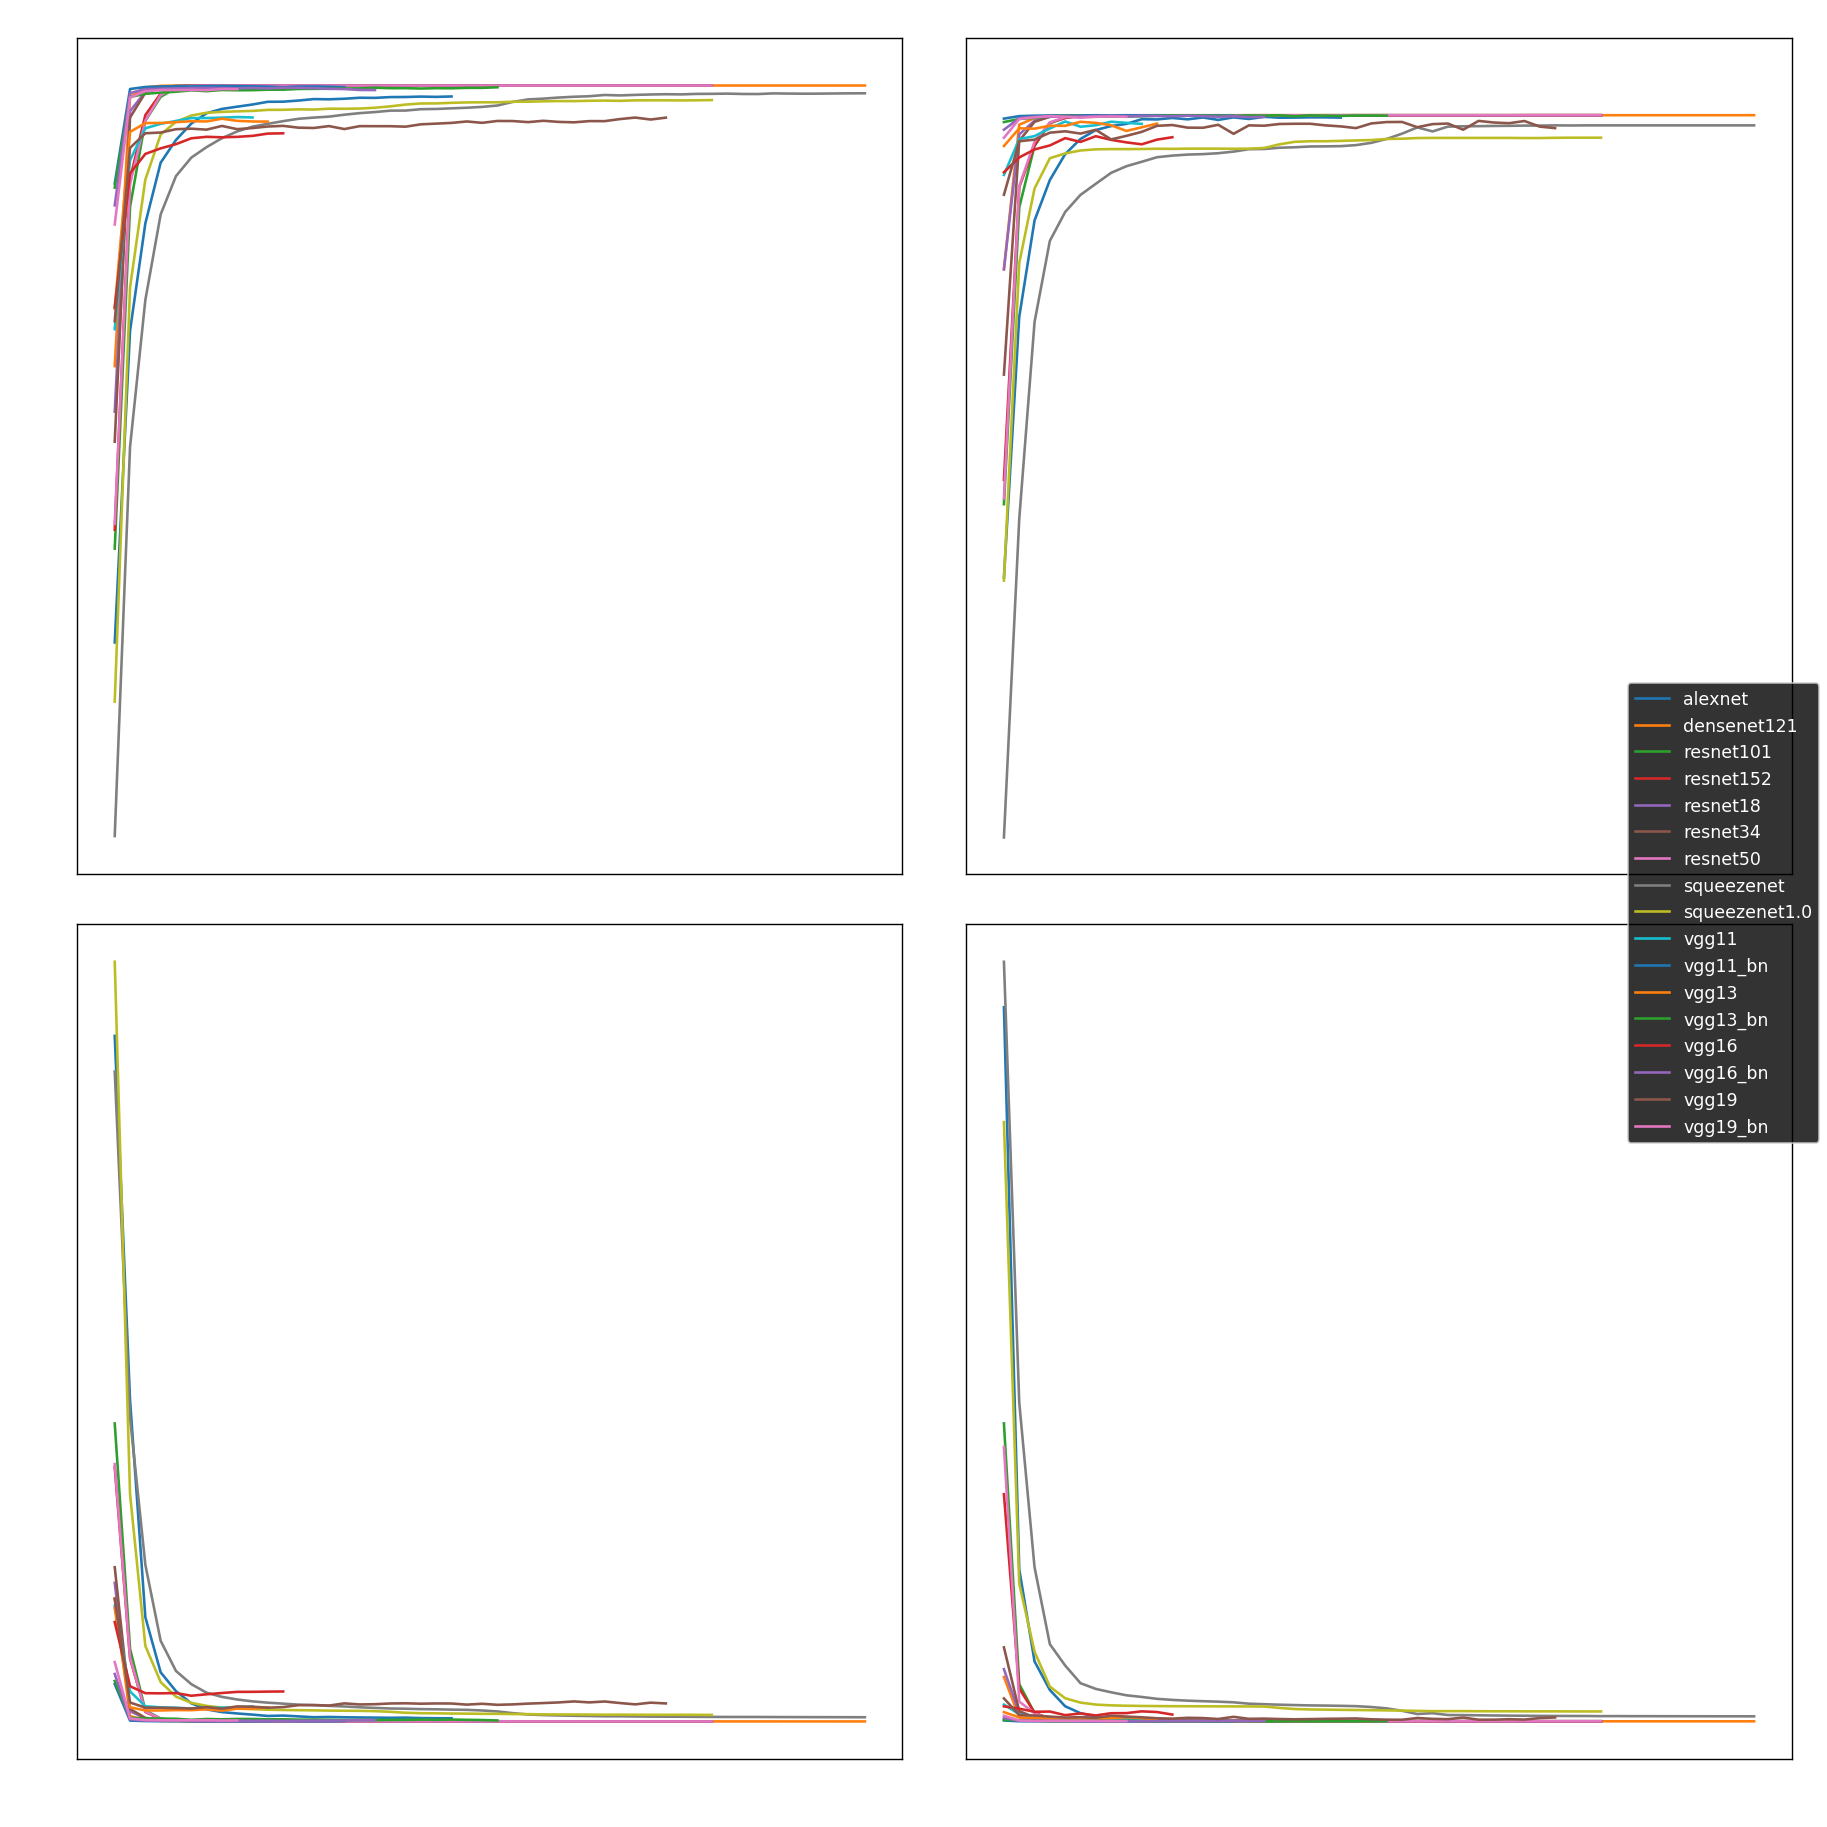

In [18]:

with open('axes', 'rb') as fr:
    ax = pickle.load(fr)
plt.show()

In [10]:
models = glob('models/pretrained/*')
n = len(files)
models

['models/pretrained\\alexnet',
 'models/pretrained\\densenet121',
 'models/pretrained\\resnet101',
 'models/pretrained\\resnet152',
 'models/pretrained\\resnet18',
 'models/pretrained\\resnet34',
 'models/pretrained\\resnet50',
 'models/pretrained\\squeezenet',
 'models/pretrained\\squeezenet1.0',
 'models/pretrained\\vgg11',
 'models/pretrained\\vgg11_bn',
 'models/pretrained\\vgg13',
 'models/pretrained\\vgg13_bn',
 'models/pretrained\\vgg16',
 'models/pretrained\\vgg16_bn',
 'models/pretrained\\vgg19',
 'models/pretrained\\vgg19_bn']

<IPython.core.display.Javascript object>


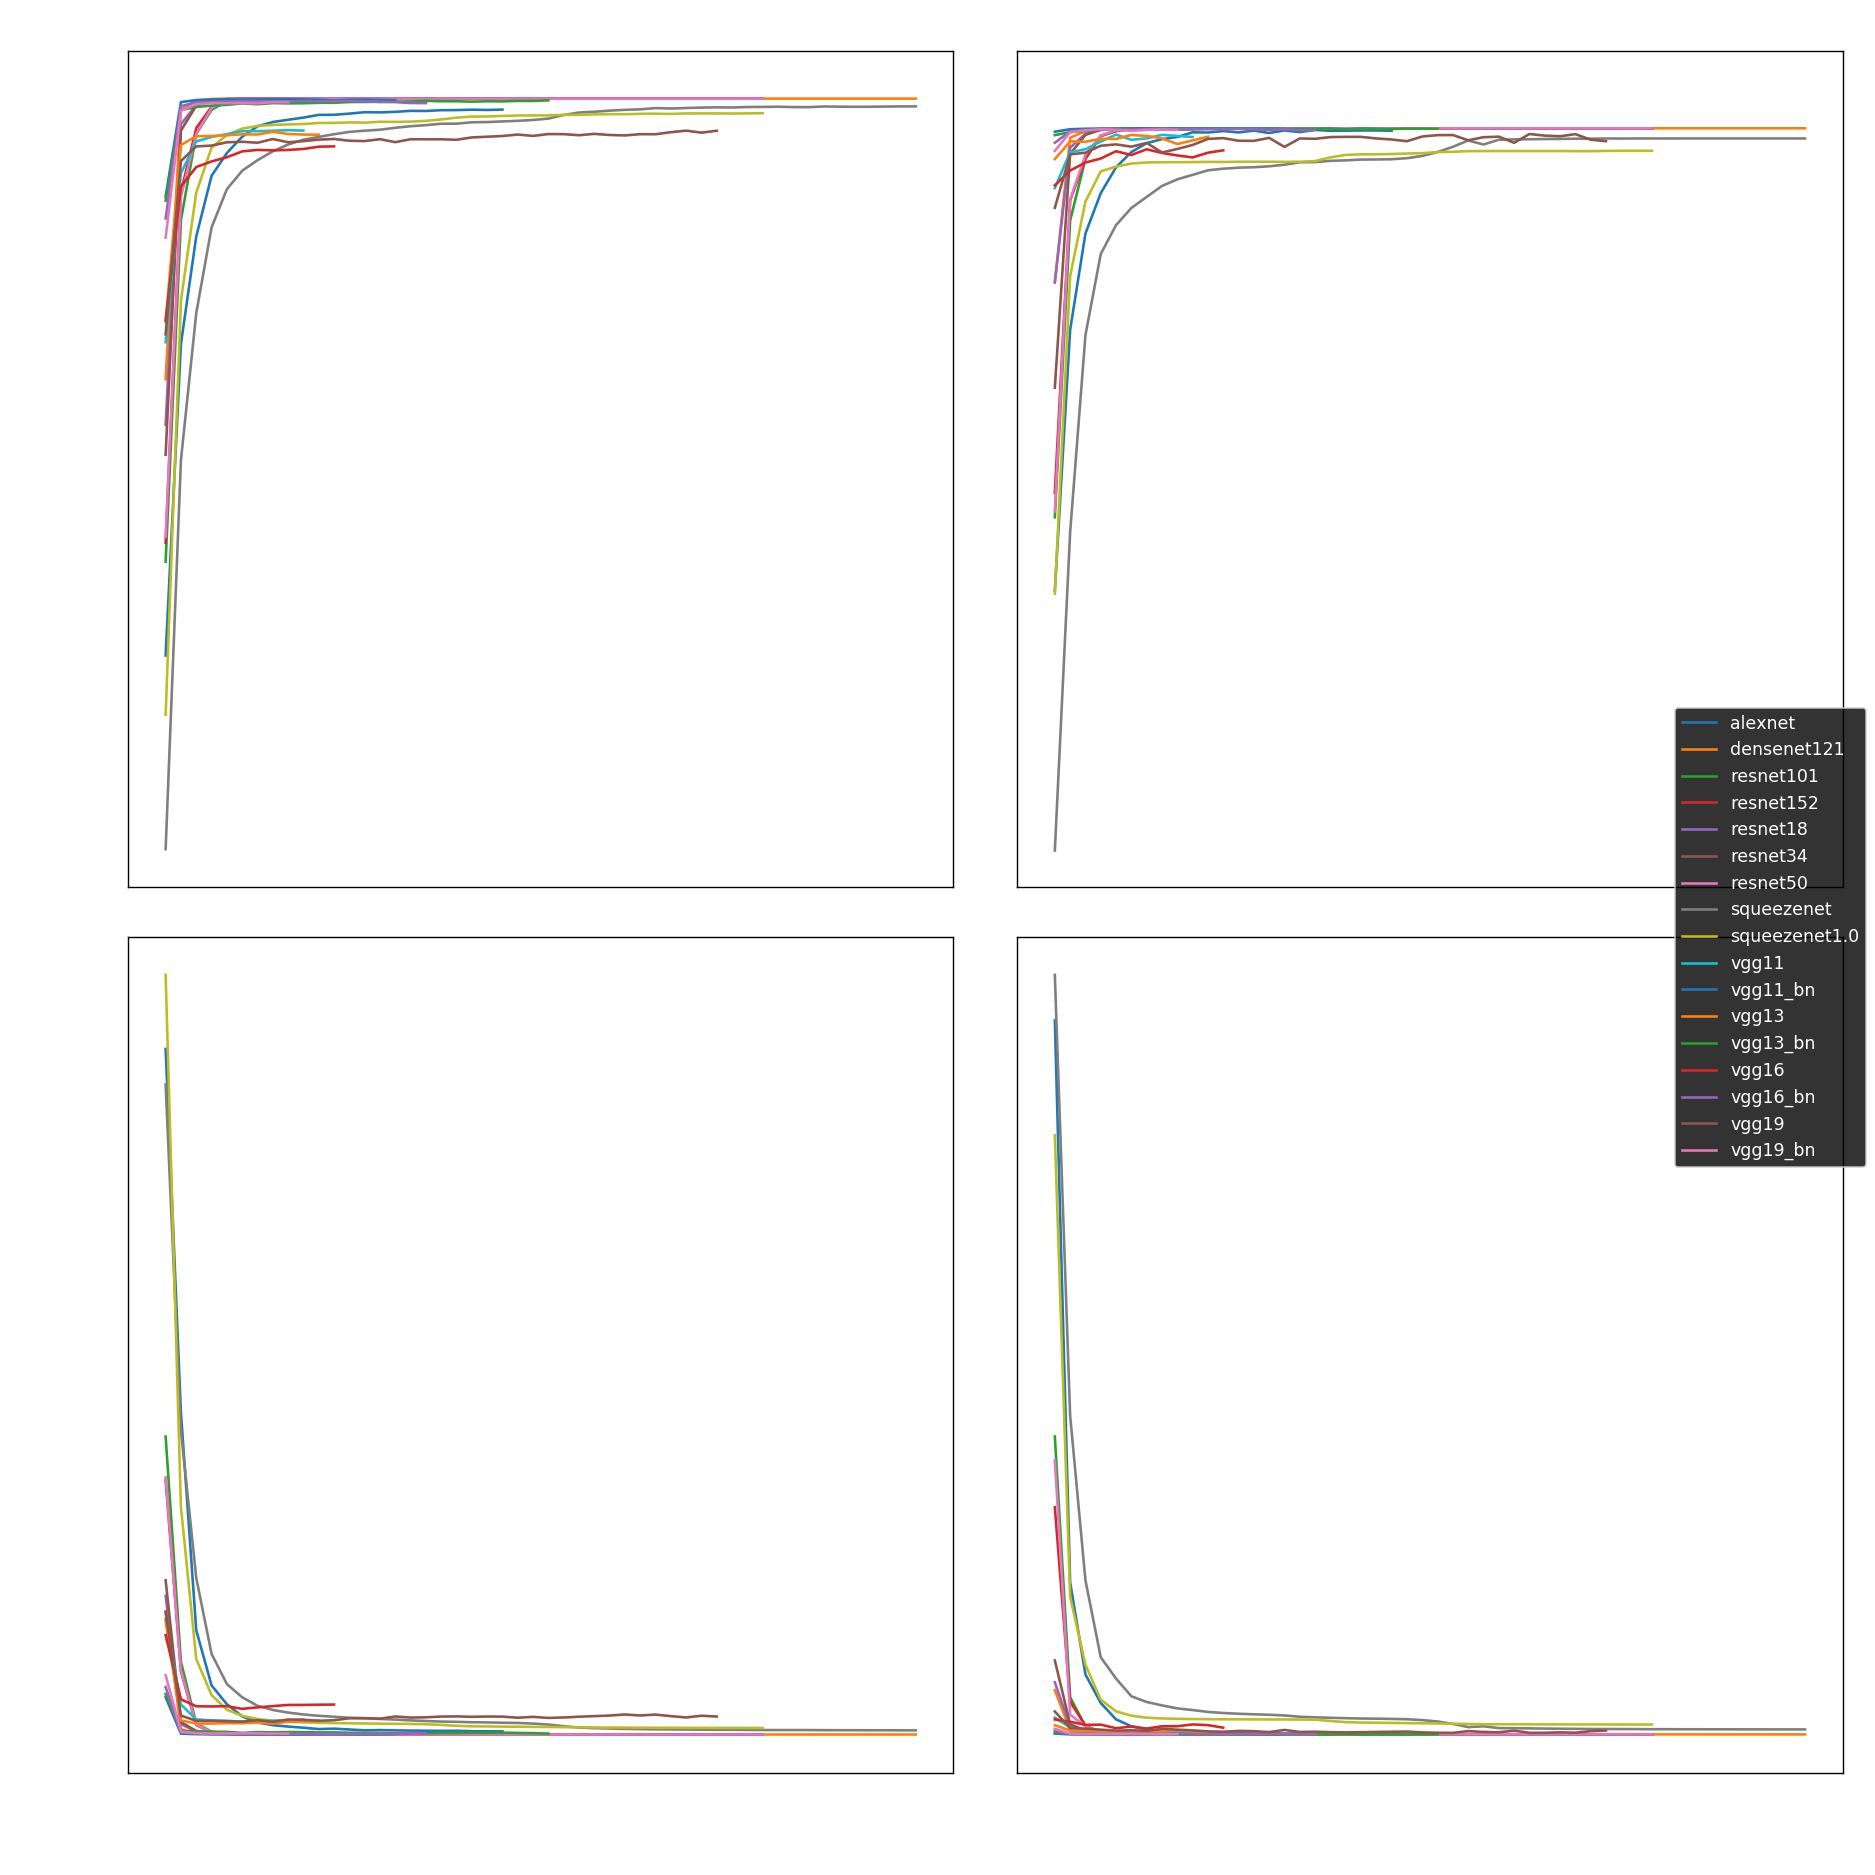

In [11]:
fig, ((train_acc, val_acc), (train_loss, val_loss)) = plt.subplots(2, 2, sharex=True, figsize=(15, 15))

for i in range(n):
    saved = torch.load(files[i])
    metrics = saved['metrics']
#     train_accs[i, :len(metrics['train_acc'])] = np.array(metrics['train_acc'])
#     train_losses[i, :len(metrics['train_loss'])] = np.array(metrics['train_loss'])
#     val_accs[i, :len(metrics['val_acc'])] = np.array(metrics['val_acc'])
#     val_losses[i, :len(metrics['val_loss'])] = np.array(metrics['val_loss'])
    #model_state_dict = saved['model_state_dict']
    # PLOT
    train_acc.plot(metrics['train_acc'], label=files[i].split('\\')[-1])
    val_acc.plot(metrics['val_acc'])
    train_loss.plot(metrics['train_loss'])
    val_loss.plot(metrics['val_loss'])
    
yticks = range(80, 110, 5)
train_acc.set_title('Training Accuracy')
train_acc.set_yticks(yticks)
val_acc.set_title('Validation Accuracy')
val_acc.set_yticks(yticks)
loss_yticks = np.arange(0, 1, 0.1)
train_loss.set_title('Training Loss')
val_loss.set_title('Validation Loss')

fig.legend(facecolor='black', loc='center right');
# add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("Epochs ->")
plt.ylabel("Metric")
plt.tight_layout()

## Save figure

In [31]:
with open('charts', 'wb') as fw:
    pickle.dump(fig, fw)

In [12]:
with open('axes', 'wb') as fw:
    pickle.dump(train_acc, fw)
    pickle.dump(val_acc, fw)
    pickle.dump(train_loss, fw)
    pickle.dump(val_loss, fw)
    

# Remove wrongly recorded test metrics

In [7]:
files = glob('models/*')
m = len(files)
files.remove('models\\pretrained')

In [9]:
for i in range(m):
    filename = files[i].split('\\')[-1]
    if not(any([filename == i.split('\\')[-1] for i in models])):
        temp = torch.load(files[i])
        del temp['metrics']['test_acc'], temp['metrics']['test_loss']
        torch.save(temp, 'models/pretrained/%s' % filename)

IndexError: list index out of range

# Model

In [28]:
if torch.cuda.is_available():
    print(torch.cuda.get_device_name())
    device = torch.device('cuda')

else:
    device = torch.device('cpu')

GeForce GTX 1050 Ti


In [30]:
train_path = "../images/Training"
test_path = "../images/Test"
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
#transformer = transforms.Compose([transforms.Resize(224), transforms.ToTensor(), normalize])
transformer = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.ImageFolder(root=train_path, transform=transformer)
test_dataset = datasets.ImageFolder(root=test_path, transform=transformer)
labels_mapping = pd.Series(train_dataset.classes)
#transforms.Compose([transforms.Resize(255), transforms.CenterCrop(224), transforms.ToTensor()])
#train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

num_classes = len(labels_mapping)

In [23]:
class Custom(nn.Module):
    url = 'https://download.pytorch.org/models/vgg16-397923af.pth'
    def __init__(self, num_classes=131, pretrained=True):
        super(Custom, self).__init__()
        self.num_classes = num_classes
        
        self.layers = nn.Sequential(
            nn.Conv2d(3, 4, kernel_size=3, padding=1)
        )
        self.clf = nn.Sequential(        
            nn.Flatten(),
            nn.Linear(4*100*100, self.num_classes)
        )
    def forward(self, x):
        x = self.layers(x)
        
        x = self.clf(x)
        return x

In [37]:
model = Custom()
model.load_state_dict(best)
model = model.to(device)
criterion = nn.CrossEntropyLoss()

In [39]:
%%time
model.eval()
t_loss = 0
test_running_loss = 0.0
test_running_corrects = 0.0
for inputs, labels in iter(test_loader):
    inputs, labels = inputs.to(device), labels.to(device)

    output = model.forward(inputs)
    test_loss = criterion(output, labels)
    t_loss += test_loss.item()
    _, test_preds = torch.max(output, 1)

    test_running_loss += test_loss.item() * inputs.size(0)
    test_running_corrects += torch.sum(test_preds == labels.data)
accuracy = test_running_corrects.double() / len(test_loader.dataset)

print("Accuracy = %f" % accuracy)
print("Test Loss = %f" % t_loss)
print("Running loss = %f" % (test_running_loss/len(test_loader.dataset)))
print("Size of Test set = %d" % len(test_loader.dataset))

Accuracy = 0.004981
Test Loss = 3467.435574
Running loss = 4.890600
Size of Test set = 22688
Wall time: 5min 44s
